# Comparing ICAs
This notebook compares ICAs on synthetic and real data. The advantage of syntheticv data is we cna know exactly what happens as we mixed the original componenets.

In [1]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random


In [2]:
# local resurf
# import our library until next release

sys.path.insert(0, '../resurfemg')
import helper_functions as hf
import multi_lead_type as mt
from tmsisdk_lite import Poly5Reader
import config as cf

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


Now we can load synthetic ECGs

In [3]:
loaded_ecg = np.load('../synth_data/synth_ecg_array.npy')
loaded_ecg.shape

(10, 307200)

Now we will make synthetic EMG

In [4]:
emg = cf.simulate_emg_with_occlusions(t_start=0,
                                 t_end=7*60,
                                 emg_sample_rate=2048,   # hertz
                                 rr=22,         # respiratory rate /min
                                 ie_ratio=1/2,  # ratio btw insp + expir phase
                                 tau_mus_up=0.3,
                                 tau_mus_down=0.3,
                                 occs_times_vals=[6*60+5, 6*60+21, 6*60+35])

In [5]:
emg1 = emg[0][:307200]
emg2 = emg[1][:307200]
emg3 = emg[2][:307200]
emg3.shape
emg_stack = np.vstack((emg1,emg2))
emg_stack = np.vstack((emg_stack,emg3))
emg_stack.shape[1]

307200

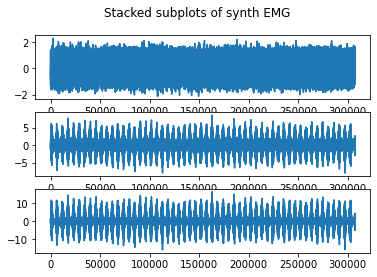

In [6]:
fig, axs = plt.subplots(3)
fig.suptitle('Stacked subplots of synth EMG')
axs[0].plot(emg_stack[0])
axs[1].plot(emg_stack[1])
axs[2].plot(emg_stack[2])

In [7]:
line = random.randint(0, 9)
one_line_ecg = loaded_ecg[line]

Now we will make out blended signal

In [8]:
x_emg = np.zeros((3,emg_stack.shape[1]))
#x_emg.shape
x_emg[0] = 200*one_line_ecg + 0.05 * emg_stack[0]
x_emg[1] = 200*one_line_ecg + 4 * emg_stack[1]
x_emg[2] = 200*one_line_ecg + 8 * emg_stack[2]

In [9]:
x_emg.shape

(3, 307200)

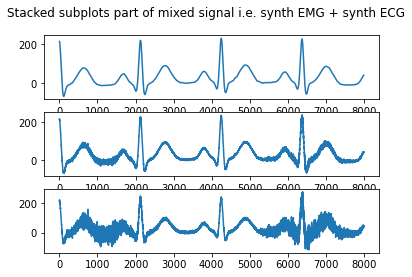

In [10]:
fig, axs = plt.subplots(3)
fig.suptitle('Stacked subplots part of mixed signal i.e. synth EMG + synth ECG')
axs[0].plot(x_emg[0][:8000])
axs[1].plot(x_emg[1][:8000])
axs[2].plot(x_emg[2][:8000])


Let's see it all together:

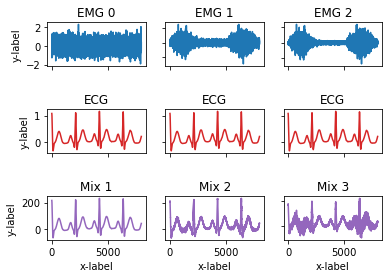

In [11]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(emg_stack[0][:8000])
axs[0, 0].set_title('EMG 0')
axs[0, 1].plot(emg_stack[1][:8000] )
axs[0, 1].set_title('EMG 1')
axs[0, 2].plot(emg_stack[2][:8000])
axs[0, 2].set_title('EMG 2')
axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 1].set_title('ECG')
axs[1, 2].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 2].set_title('ECG')
axs[2, 0].plot(x_emg[0][:8000], 'tab:purple')
axs[2, 0].set_title('Mix 1')
axs[2, 1].plot(x_emg[1][:8000], 'tab:purple')
axs[2, 1].set_title('Mix 2')
axs[2, 2].plot(x_emg[2][:8000], 'tab:purple')
axs[2, 2].set_title('Mix 3')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

Let's get amplitude differences

In [12]:

emg_amplitide_lead0 = emg_stack[0][:8000].max() - emg_stack[0][:8000].min()
emg_amplitide_lead1 = emg_stack[1][:8000].max() - emg_stack[1][:8000].min()
emg_amplitide_lead2 = emg_stack[2][:8000].max() - emg_stack[2][:8000].min()
eCg_amplitide_lead0 = one_line_ecg[:8000].max() - one_line_ecg.min()
eCg_amplitide_lead1 = one_line_ecg[:8000].max() - one_line_ecg.min()
eCg_amplitide_lead2 = one_line_ecg[:8000].max() - one_line_ecg.min()
x_emg_amplitude_lead0 = x_emg[0][:8000].max() - x_emg[0][:8000].min()
x_emg_amplitude_lead1 = x_emg[1][:8000].max() - x_emg[1][:8000].min()
x_emg_amplitude_lead2 = x_emg[2][:8000].max() - x_emg[2][:8000].min()

In [13]:

print("EMG lead amplitudes:", emg_amplitide_lead0, emg_amplitide_lead1, emg_amplitide_lead2)
print("EcG lead amplitudes:", eCg_amplitide_lead0, eCg_amplitide_lead1, eCg_amplitide_lead2)

EMG lead amplitudes: 4.205578404626079 13.443087351541994 25.254309607575024
EcG lead amplitudes: 1.5610996492360991 1.5610996492360991 1.5610996492360991


But now let's remember we multiply the ECG these by a certain number i.e. 200 when we do the mixing, and same for the ECG. Let's get the real amplitudes:

In [14]:

print("Real mix EMG lead amplitudes:", 0.05*emg_amplitide_lead0, 4*emg_amplitide_lead1, 8*emg_amplitide_lead2)
print("Real mix EcG lead amplitudes:", 200*eCg_amplitide_lead0, 200*eCg_amplitide_lead1, 200*eCg_amplitide_lead2)
print("Real total mixed signal lead amplitudes:", x_emg_amplitude_lead0,x_emg_amplitude_lead1, x_emg_amplitude_lead2)

Real mix EMG lead amplitudes: 0.21027892023130398 53.772349406167976 202.0344768606002
Real mix EcG lead amplitudes: 312.2199298472198 312.2199298472198 312.2199298472198
Real total mixed signal lead amplitudes: 298.8582676149376 307.5214161853936 393.1433912133311


Now we can run different ICAs over our data and see if different ICAs are in fact different, and how they compare.
Warning: these functions take a really long time to run.

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


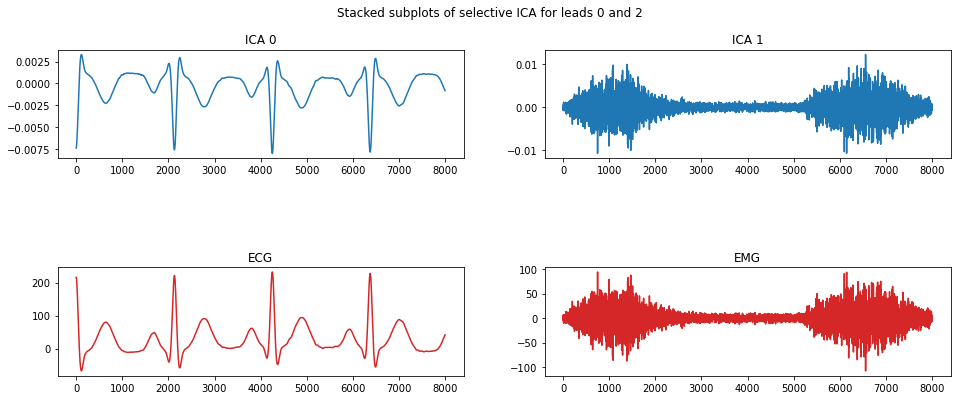

In [15]:
selective_ica = mt.compute_ICA_two_comp_selective(
    x_emg,
    use_all_leads=False,
    desired_leads=(0, 2),
)
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
fig.suptitle('Stacked subplots of selective ICA for leads 0 and 2')
axs[0, 0].plot(selective_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(selective_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')

axs[1, 0].plot(one_line_ecg[:8000] *200, 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(emg_stack[2][:8000]*8, 'tab:red')
axs[1, 1].set_title('EMG')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


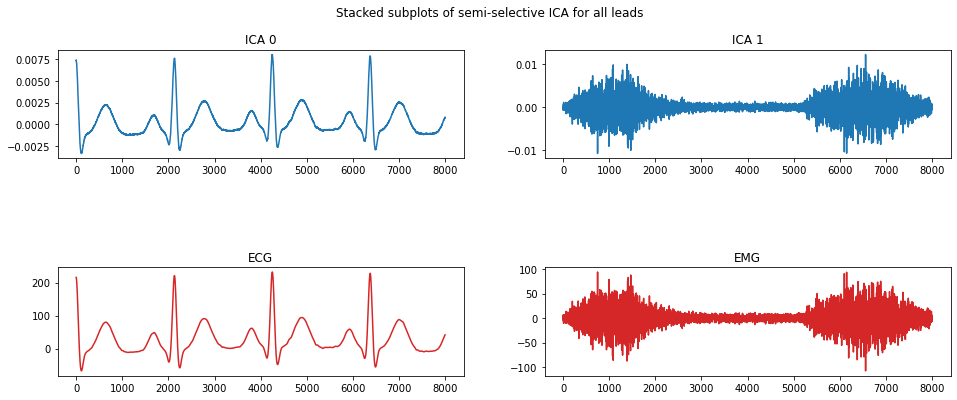

In [16]:
semi_selective_ica = mt.compute_ICA_two_comp_selective(
    x_emg,
    use_all_leads=True,
)
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
fig.suptitle('Stacked subplots of semi-selective ICA for all leads')
axs[0, 0].plot(semi_selective_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(semi_selective_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')

axs[1, 0].plot(one_line_ecg[:8000]*200, 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(emg_stack[2][:8000]*8, 'tab:red')
axs[1, 1].set_title('EMG')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


Observation: when we don't select the most extreme leads we get worse results (notice our ecg-found is more shaky/contaminated). Also notice our amplitudes are not good. Not surprising. Moving on,.

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


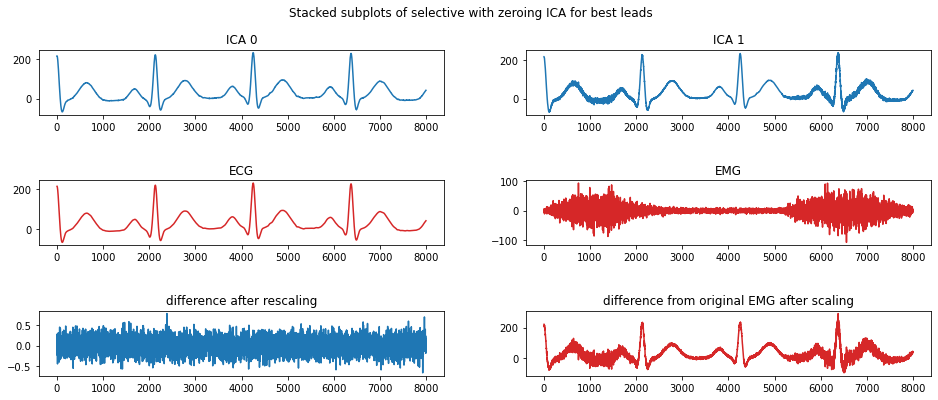

In [17]:
zerod_ica = mt.compute_ICA_n_comp_selective_zeroing(
    x_emg,
    use_all_leads=True,
    #desired_leads=(0, 2),
    lead_to_remove= 0,
)
fig, axs = plt.subplots(3, 2, figsize=(16, 6))
fig.suptitle('Stacked subplots of selective with zeroing ICA for best leads')
axs[0, 0].plot(zerod_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(zerod_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')
axs[2, 0].plot(zerod_ica[0][:8000] - 200*one_line_ecg[:8000])
axs[2, 0].set_title('difference after rescaling')
axs[1, 0].plot(one_line_ecg[:8000]* 200, 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(emg_stack[2][:8000]*8, 'tab:red')
axs[1, 1].set_title('EMG')
axs[2, 1].plot(zerod_ica[1][:8000] - emg_stack[2][:8000]*8, 'tab:red')
axs[2, 1].set_title('difference from original EMG after scaling')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


Observation: that was a bad idea. This was actuallty a worse result in multiple ways, maybe including the way amplitudes compare except that we get close to the right amplitude and form on the ECG back. Interesting that Maybe we need to zero something else as RW suggests. I hope his algorithm also returns the right amplitude but has better results. 

Let's see what happens if we take out the other lead instead

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


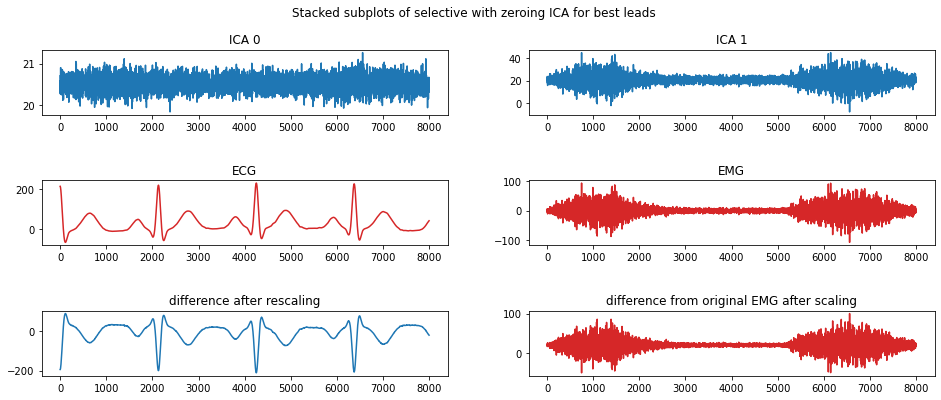

In [18]:
zerod_ica_2 = mt.compute_ICA_n_comp_selective_zeroing(
    x_emg,
    use_all_leads=True,
    #desired_leads=(0, 2),
    lead_to_remove= 2,
)
fig, axs = plt.subplots(3, 2, figsize=(16, 6))



fig.suptitle('Stacked subplots of selective with zeroing ICA for best leads')
axs[0, 0].plot(zerod_ica_2[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(zerod_ica_2[1][:8000] )
axs[0, 1].set_title('ICA 1')
axs[2, 0].plot(zerod_ica_2[0][:8000] - 200*one_line_ecg[:8000])
axs[2, 0].set_title('difference after rescaling')
axs[1, 0].plot(one_line_ecg[:8000] *200, 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(emg_stack[2][:8000] *8, 'tab:red')
axs[1, 1].set_title('EMG')
axs[2, 1].plot(zerod_ica_2[1][:8000] - 8*emg_stack[2][:8000], 'tab:red')
axs[2, 1].set_title('difference from original EMG after scaling')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


Now t we get a better shape on the (EMG) lead we want? Looks like setting the lead we want to reconstruct to zero will give us a more accurate ICA for that lead if we do zeroing, but not even with amplitudes or amplitude radio intact. 

Another thing to consider is maybe we should go with grabbing the ECG then subtracting it from all our signals. On our data this might work best. Or we could even try subtracting the ECG lead from the  mixed signal...but in this exercise where we had perfectly control the  signals  that can get redundant. Nonetheless, let's hammer a point home...

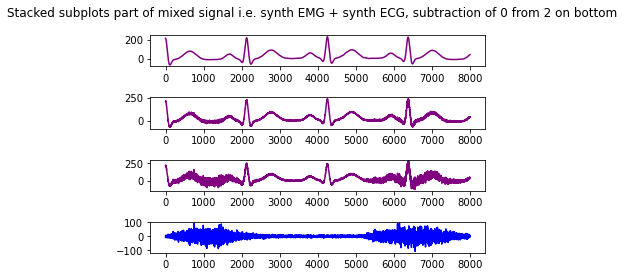

In [19]:
# Try subtracting just to show
fig, axs = plt.subplots(4)
fig.suptitle('Stacked subplots part of mixed signal i.e. synth EMG + synth ECG, subtraction of 0 from 2 on bottom')
axs[0].plot(x_emg[0][:8000], color='purple')
axs[1].plot(x_emg[1][:8000], color='purple')
axs[2].plot(x_emg[2][:8000], color='purple')
axs[3].plot(x_emg[2][:8000] -x_emg[0][:8000], color='blue' )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

This won't work when when leads are more "mixed", but for our data it should actually work fine. We cxan modify and do this procedure on the point after the ICA. In fact, if we assume the heart lead will always dominate in any ICAwe can subtract either ICA from the other.

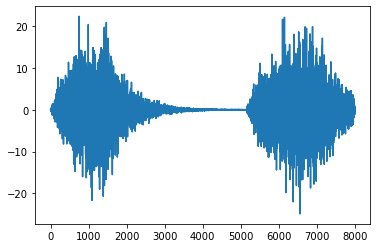

In [20]:
plt.plot(zerod_ica[1][:8000]- zerod_ica[0][:8000])

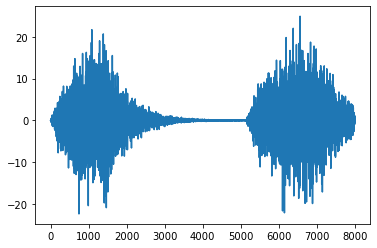

In [21]:
# and of course the other way around is just upside down, which will go away with abs
plt.plot(zerod_ica[0][:8000]- zerod_ica[1][:8000])

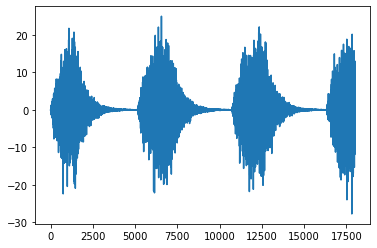

In [22]:
# looking farther
plt.plot(zerod_ica[0][:18000]- zerod_ica[1][:18000])

So maybe the correct algorithm in our case is to just subtract one ICA from the other? Here again the amplitude is not particularly reality based though. 